In [1]:
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler , WeightedRandomSampler
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

In [2]:
class DigitDataset(Dataset):
        
    def __init__(self,root_dir,train=True):
        data = np.array(pd.read_csv(root_dir))
        self.len = data.shape[0]
        self.train = train
        if train:
            self.x_data = torch.from_numpy(data[:,1:]/255)
            self.y_data = torch.from_numpy(data[:,0])
        else:    
            self.x_data = torch.from_numpy(data/255)
              
    def __getitem__(self,index):
         if self.train == False :
            return self.x_data[index] 
         else:
            return self.x_data[index] , self.y_data[index]
           
    def __len__(self):
         return self.len

In [3]:
traindata = DigitDataset('Data/train.csv')
testdata = DigitDataset('Data/test.csv',train=False)

In [4]:
validation_split = 0.8
dataset_size = len(traindata)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(123)
    np.random.shuffle(indices)
train_indices, valid_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [13]:
train_set = DataLoader(dataset=traindata,batch_size=512,sampler=train_sampler)
val_set = DataLoader(dataset=traindata,batch_size=2048,sampler=valid_sampler)
test_set = DataLoader(dataset=testdata,batch_size=32,shuffle=False)   

In [6]:
for data in test_set:
    print(data.shape)
    break

torch.Size([128, 784])


In [7]:
class Net(nn.Module):
        def __init__(self):
            super(Net,self).__init__()
            self.layer1 = nn.Sequential (
                nn.Conv2d(1,32,kernel_size=3,bias=False,stride=1,padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2),
            )
            self.layer2 = nn.Sequential (
                nn.Conv2d(32,64,kernel_size=3,bias=False,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2),
            )
            self.layer3 = nn.Sequential (
                nn.Conv2d(64,128,kernel_size=3,bias=False,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3,stride=2),
            )
            self.layer4 = nn.Sequential (
                nn.Linear(3*3*128,128),
                nn.Linear(128,10),
                nn.LogSoftmax(dim=1),
            )
        def forward(self,x):
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = x.reshape(x.size(0),-1)
            x = self.layer4(x)
            return x

In [8]:
import torch.optim as optim

In [9]:
net = Net()

In [10]:
def training(train_set=train_set):
    
        EPOCHS = 12
    
        LOSS = []
        
        LR = 0.001
        
        seed = 3
        
        optimizer = optim.Adam(net.parameters(),lr=LR)   
        
        for epoch in range(EPOCHS): 
            t=0
    #         if epoch > 7:
    #             LR = LR/100
            
            for data in tqdm(train_set):
                X,y = data
                X = (X/255).view(-1,1,28,28).float()
                net.zero_grad()
                output = net(X)
                loss = F.nll_loss(output,y)
                loss.backward()
                optimizer.step()
                LOSS.append(loss)
                if (t+1) % 33 == 0:
                    print(loss)
                t+=1    
                
        plt.plot(LOSS)
        return LOSS

In [11]:
 def val(val_set=val_set,train_set=train_set):
        wrong_idx = []    
        correct1 = 0
        total1 = 0
        correct2 = 0
        total2 = 0
        with torch.no_grad():
            for data in val_set:
                X,y = data
                X = (X/255).view(-1,1,28,28).float()
                output1 = net(X)
                for idx,i in enumerate(output1):
                    if torch.argmax(i) == y[idx]:
                        correct1+=1
                    else:
                        wrong_idx.append(idx)
                    total1+=1
            for data in train_set:    
                X,y = data
                X = (X/255).view(-1,1,28,28).float()
                output2 = net(X)
                for idx,i in enumerate(output2):
                    if torch.argmax(i) == y[idx]:
                        correct2+=1
                    else:
                        wrong_idx.append(idx)
                    total2+=1
        print(f'val accuacy:{correct1/total1}')
        print(f'train accuacy:{correct2/total2}')    

 50%|█████████████████████████████████████████                                         | 33/66 [01:02<01:00,  1.83s/it]

tensor(0.2406, grad_fn=<NllLossBackward>)


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

tensor(0.1155, grad_fn=<NllLossBackward>)


 50%|█████████████████████████████████████████                                         | 33/66 [00:58<00:57,  1.74s/it]

tensor(0.0511, grad_fn=<NllLossBackward>)


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

tensor(0.1103, grad_fn=<NllLossBackward>)


 50%|█████████████████████████████████████████                                         | 33/66 [00:57<00:55,  1.70s/it]

tensor(0.0240, grad_fn=<NllLossBackward>)


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

tensor(0.0560, grad_fn=<NllLossBackward>)


 50%|█████████████████████████████████████████                                         | 33/66 [00:58<01:00,  1.84s/it]

tensor(0.0258, grad_fn=<NllLossBackward>)


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

tensor(0.0478, grad_fn=<NllLossBackward>)


 50%|█████████████████████████████████████████                                         | 33/66 [01:00<01:00,  1.82s/it]

tensor(0.0214, grad_fn=<NllLossBackward>)


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

tensor(0.0133, grad_fn=<NllLossBackward>)


 50%|█████████████████████████████████████████                                         | 33/66 [01:00<00:59,  1.80s/it]

tensor(0.0219, grad_fn=<NllLossBackward>)


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

tensor(0.0277, grad_fn=<NllLossBackward>)


 50%|█████████████████████████████████████████                                         | 33/66 [00:59<01:00,  1.84s/it]

tensor(0.0067, grad_fn=<NllLossBackward>)


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

tensor(0.0448, grad_fn=<NllLossBackward>)


 50%|█████████████████████████████████████████                                         | 33/66 [00:58<00:58,  1.78s/it]

tensor(0.0080, grad_fn=<NllLossBackward>)


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

tensor(0.0033, grad_fn=<NllLossBackward>)


 50%|█████████████████████████████████████████                                         | 33/66 [00:58<01:01,  1.85s/it]

tensor(0.0045, grad_fn=<NllLossBackward>)


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

tensor(0.0061, grad_fn=<NllLossBackward>)


 50%|█████████████████████████████████████████                                         | 33/66 [00:58<00:58,  1.78s/it]

tensor(0.0023, grad_fn=<NllLossBackward>)


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

tensor(0.0028, grad_fn=<NllLossBackward>)


 50%|█████████████████████████████████████████                                         | 33/66 [00:58<00:58,  1.76s/it]

tensor(0.0021, grad_fn=<NllLossBackward>)


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

tensor(0.0038, grad_fn=<NllLossBackward>)


 50%|█████████████████████████████████████████                                         | 33/66 [00:59<00:58,  1.76s/it]

tensor(0.0014, grad_fn=<NllLossBackward>)


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [01:57<00:00,  1.78s/it]

tensor(0.0021, grad_fn=<NllLossBackward>)


val accuacy:0.9916666666666667
train accuacy:0.9999702380952381


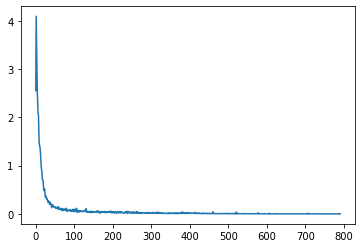

In [12]:
net = Net()
LOSS = training()
val()

In [12]:
# pickle.dump(net,open('Digits_CNN-3C-1L-sub-1','wb'))
c= pickle.load(open('Digits_CNN-3C-1L-sub-1','rb'))

In [24]:
test_data = []
for data in tqdm(test_set):
    test_data.append(data.view(-1,1,28,28).float())

100%|██████████████████████████████████████████████████████████████████████████████| 875/875 [00:00<00:00, 1674.33it/s]


In [27]:
len(test_data)

875

In [ ]:
predictions = [] 

In [32]:
for i in tqdm(range(len(test_data))):
    predictions.append(c(test_data[i]))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [11:05<00:00,  2.22s/it]


In [44]:
Final_predictions = []
for i in range(875):
    for j  in range(32):
        Final_predictions.append(torch.argmax(predictions[i][j]))

In [52]:
pred = np.array(Final_predictions)

In [54]:
predictions = pd.DataFrame(pred,columns=['Label'])

In [55]:
predictions = pd.concat([pd.DataFrame({'ImageId':np.arange(1,28001,1)}),predictions],axis=1)

In [56]:
predictions.to_csv('../Digit/Data/submission2.csv',index=False)